# Pandas in Depth 

based on https://medium.com/fintechexplained/did-you-know-pandas-can-do-so-much-f65dc7db3051

## Objectives: 
   1. Get data from a cube
   1. Calculate the Median and Standard Deviation
   1. Send these values back to TM1
   

# Ways to build Pandas DataFrames from TM1 data

In [71]:
import numpy as np
import pandas as pd

import statistics

In [72]:
# This mdx will be used as data in this example
mdx = """
SELECT 
NON EMPTY {[Date].[2014-01-01]:[Date].[2017-12-31]} ON ROWS,
{[City].[NYC], [City].[Chicago], [City].[Washington]} ON COLUMNS
FROM [Bike Shares]
WHERE ([Bike Shares Measure].[Count], [Version].[Actual])
"""

*The cube **Bike Shares** is coming from the **tm1py-samples\Samples\Cubike\cubike_setup.py**, you can execute this script to create the **Bike Shares** cube.*

In [73]:
# Create the TM1 service
from TM1py.Services import TM1Service

tm1 = TM1Service(address='localhost', port=8009, user='admin', password='apple', ssl=True)

## 1. Getting data from TM1 then building the dataframe

In [74]:
# retrieve a dictionary through TM1py and build a DataFrame from it
from TM1py.Utils.Utils import build_pandas_dataframe_from_cellset

data = tm1.cubes.cells.execute_mdx(mdx)

df = build_pandas_dataframe_from_cellset(data, multiindex=False)
df.head()

,Version,Date,City,Bike Shares Measure,Values
1,Actual,2014-01-01,Chicago,Count,123.0
0,Actual,2014-01-01,NYC,Count,6059.0
2,Actual,2014-01-01,Washington,Count,3011.0
4,Actual,2014-01-02,Chicago,Count,112.0
3,Actual,2014-01-02,NYC,Count,8600.0


## 2. Retrieving a dataframe from TM1

In [75]:
# retrieve DataFrame directly
df = tm1.cubes.cells.execute_mdx_dataframe(mdx)
df.head()

,Date,City,Value
0,2014-01-01,NYC,6059
1,2014-01-01,Chicago,123
2,2014-01-01,Washington,3011
3,2014-01-02,NYC,8600
4,2014-01-02,Chicago,112


## Building a pivot table

In [76]:
# Transform into something more convenient
for city in ('NYC', 'Chicago', 'Washington'):
    df[city] = df.apply(lambda row: row["Value"] if row["City"] == city else None, axis=1)
df.drop(columns=["Value"], inplace=True)
df = df.groupby("Date").sum()

In [77]:
# Getting the first 5 rows
df.head()

,NYC,Chicago,Washington
Date,,,
2014-01-01,6059.0,123.0,3011.0
2014-01-02,8600.0,112.0,3316.0
2014-01-03,1144.0,6.0,1608.0
2014-01-04,2292.0,205.0,2242.0
2014-01-05,2678.0,33.0,2060.0


In [79]:
# retrieve a pivot DataFrame from a cubeview / MDX Query 
pivot = tm1.cubes.cells.execute_mdx_dataframe_pivot(mdx)
pivot.head(10)

Values                    
City       Chicago      NYC Washington
Date                                  
2014-01-01   123.0   6059.0     3011.0
2014-01-02   112.0   8600.0     3316.0
2014-01-03     6.0   1144.0     1608.0
2014-01-04   205.0   2292.0     2242.0
2014-01-05    33.0   2678.0     2060.0
2014-01-06     1.0   9510.0     3507.0
2014-01-07     0.0   6267.0     2282.0
2014-01-08     0.0   9246.0     3855.0
2014-01-09   860.0  13354.0     4948.0
2014-01-10   823.0   9847.0     1843.0

# Engineering and Analysis on Pandas DataFrames
## head, tail, sample

In [15]:
# head() returns the first 5 records
df.head()

,NYC,Chicago,Washington
Date,,,
2014-01-01,6059.0,123.0,3011.0
2014-01-02,8600.0,112.0,3316.0
2014-01-03,1144.0,6.0,1608.0
2014-01-04,2292.0,205.0,2242.0
2014-01-05,2678.0,33.0,2060.0


In [16]:
# tail() returns the last 5 records
df.tail()

,NYC,Chicago,Washington
Date,,,
2017-12-27,16365.0,1138.0,3321.0
2017-12-28,13420.0,1294.0,2866.0
2017-12-29,13759.0,1076.0,3088.0
2017-12-30,5956.0,548.0,1876.0
2017-12-31,6569.0,651.0,1437.0


In [17]:
# sample(n) retrieves n random lines
df.sample(5)

,NYC,Chicago,Washington
Date,,,
2016-08-18,53218.0,13365.0,11821.0
2015-11-15,25990.0,7707.0,7441.0
2015-03-09,14878.0,4362.0,7942.0
2017-05-13,5704.0,15015.0,8177.0
2015-08-11,25066.0,17489.0,11342.0


## Accessing cells

In [24]:
df.loc['2016-08-11']['NYC']

47430.0

In [80]:
# accessing cells in pivot
df.loc[("2017-12-31")]

NYC           6569.0
Chicago        651.0
Washington    1437.0
Name: 2017-12-31, dtype: float64

In [82]:
pivot.loc[("2017-12-31")]["Values"]["NYC"]

6569.0

## Sorting

In [27]:
df.sort_values(by=['NYC'], ascending=True).head(10)

,NYC,Chicago,Washington
Date,,,
2016-01-24,0.0,1988.0,0.0
2016-01-25,0.0,4078.0,0.0
2016-01-26,0.0,4327.0,0.0
2017-03-16,0.0,4989.0,5179.0
2017-03-15,0.0,3598.0,3359.0
2017-03-14,0.0,1746.0,1583.0
2016-01-23,0.0,2279.0,0.0
2017-02-09,0.0,4127.0,5369.0
2014-02-13,876.0,1389.0,52.0


## filtering

In [28]:
df.loc[lambda df: df['NYC'] > 74000]

,NYC,Chicago,Washington
Date,,,
2017-09-12,74580.0,17453.0,14497.0
2017-10-10,74118.0,10648.0,13153.0


## filter and sort

In [29]:
df.loc[lambda df: df['NYC'] > 74000].sort_index(ascending=False)

,NYC,Chicago,Washington
Date,,,
2017-10-10,74118.0,10648.0,13153.0
2017-09-12,74580.0,17453.0,14497.0


## Transpose

In [30]:
df.head().T

Date,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05
NYC,6059.0,8600.0,1144.0,2292.0,2678.0
Chicago,123.0,112.0,6.0,205.0,33.0
Washington,3011.0,3316.0,1608.0,2242.0,2060.0


## Describe() to get a quick summary of your data frame

In [32]:
df.describe()

,NYC,Chicago,Washington
count,1461.000000,1461.000000,1461.000000
mean,33011.291581,8940.773443,9028.629021
std,17316.021157,5806.161916,3564.236783
min,0.000000,0.000000,0.000000
25%,19695.000000,3733.000000,6074.000000
50%,32419.000000,8264.000000,9848.000000
75%,44553.000000,14197.000000,11821.000000
max,74580.000000,24989.000000,16896.000000


## Apply a custom function

In [36]:
# Create a new column called 'Total'
df['Total'] = df['NYC'] + df['Chicago'] + df['Washington']
# Create a  new column 'Mean'
df['Mean'] = df['Total'] / 3

In [37]:
df.head()

,NYC,Chicago,Washington,Total,Mean
Date,,,,,
2014-01-01,6059.0,123.0,3011.0,9193.0,3064.333333
2014-01-02,8600.0,112.0,3316.0,12028.0,4009.333333
2014-01-03,1144.0,6.0,1608.0,2758.0,919.333333
2014-01-04,2292.0,205.0,2242.0,4739.0,1579.666667
2014-01-05,2678.0,33.0,2060.0,4771.0,1590.333333


## Rolling Moving Average With Window

In [38]:
df['NYC Rolling Median'] = df['NYC'].rolling(window=10,).median()

In [39]:
df['NYC Rolling StdDev'] = df['NYC'].rolling(window=10,).std()

In [40]:
df.tail(10)

,NYC,Chicago,Washington,Total,Mean,NYC Rolling Median,NYC Rolling StdDev
Date,,,,,,,
2017-12-22,34341.0,4576.0,6159.0,45076.0,15025.333333,33482.0,9751.619806
2017-12-23,9608.0,1727.0,2464.0,13799.0,4599.666667,30918.0,12196.708518
2017-12-24,13216.0,403.0,2041.0,15660.0,5220.000000,28642.5,13362.247531
2017-12-25,6479.0,240.0,1041.0,7760.0,2586.666667,28372.0,15097.236422
2017-12-26,14113.0,779.0,2789.0,17681.0,5893.666667,28372.0,15476.560005
2017-12-27,16365.0,1138.0,3321.0,20824.0,6941.333333,25353.0,15785.700251
2017-12-28,13420.0,1294.0,2866.0,17580.0,5860.000000,15239.0,15434.122651
2017-12-29,13759.0,1076.0,3088.0,17923.0,5974.333333,13936.0,12661.142113
2017-12-30,5956.0,548.0,1876.0,8380.0,2793.333333,13589.5,10830.859394


# Apply any function a column

In [41]:
# Uses pipe to apply the function 'abs' to all values in the column 'NYC'
df['NYC'] = df['NYC'].pipe(func=abs)
df.tail(5)

,NYC,Chicago,Washington,Total,Mean,NYC Rolling Median,NYC Rolling StdDev
Date,,,,,,,
2017-12-27,16365.0,1138.0,3321.0,20824.0,6941.333333,25353.0,15785.700251
2017-12-28,13420.0,1294.0,2866.0,17580.0,5860.000000,15239.0,15434.122651
2017-12-29,13759.0,1076.0,3088.0,17923.0,5974.333333,13936.0,12661.142113
2017-12-30,5956.0,548.0,1876.0,8380.0,2793.333333,13589.5,10830.859394
2017-12-31,6569.0,651.0,1437.0,8657.0,2885.666667,13318.0,8248.504150


## To csv, to xlsx

In [42]:
df.to_csv("out.csv")

# Plotting Pandas DataFrames

In [43]:
%matplotlib inline

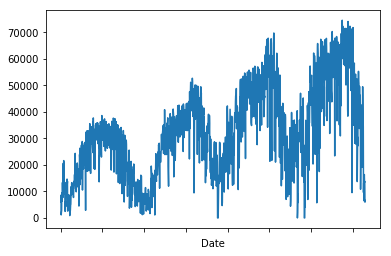

In [44]:
df['NYC'].plot.line()

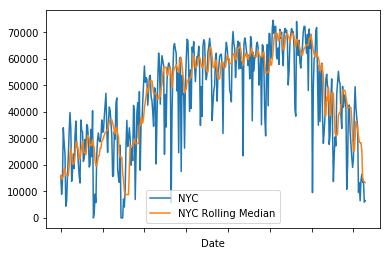

In [45]:
df.filter(like='2017', axis=0)[['NYC', 'NYC Rolling Median']].plot.line()

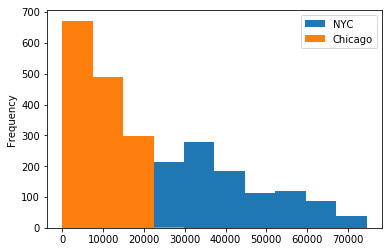

In [46]:
df[['NYC', 'Chicago']].plot.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B69646A9E8>,
      dtype=object)

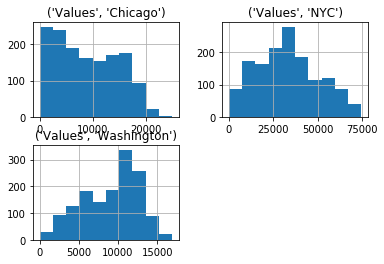

In [47]:
pivot.hist()

# Writing DataFrames back to TM1

In [48]:
# We want to send back to TM1 the two columns Rolling Median and Rolling StdDev
df_writeback = df[['NYC Rolling Median', 'NYC Rolling StdDev']]

In [49]:
df_writeback.head(10)

,NYC Rolling Median,NYC Rolling StdDev
Date,,
2014-01-01,NaN,NaN
2014-01-02,NaN,NaN
2014-01-03,NaN,NaN
2014-01-04,NaN,NaN
2014-01-05,NaN,NaN
2014-01-06,NaN,NaN
2014-01-07,NaN,NaN
2014-01-08,NaN,NaN
2014-01-09,NaN,NaN


In [52]:
# Convert the NaN values into 0
df_writeback = df_writeback.fillna(0)

In [57]:
df_writeback.head(10)

,NYC Rolling Median,NYC Rolling StdDev
Date,,
2014-01-01,0.0,0.000000
2014-01-02,0.0,0.000000
2014-01-03,0.0,0.000000
2014-01-04,0.0,0.000000
2014-01-05,0.0,0.000000
2014-01-06,0.0,0.000000
2014-01-07,0.0,0.000000
2014-01-08,0.0,0.000000
2014-01-09,0.0,0.000000


In [58]:
cellset = {}

In [61]:
# Prepare the cellset
for date in df_writeback.index:
    cellset[('Actual', date, 'NYC', 'Rolling Median')] = median = df_writeback.loc[date]['NYC Rolling Median']
    cellset[('Actual', date, 'NYC', 'Rolling StdDev')] = stddev = df_writeback.loc[date]['NYC Rolling StdDev']

In [62]:
#Before executing this scritp check that 'Rolling Median' and 'Rolling StdDev' exist in the Bike Shares Measure dimension

In [64]:
tm1.cubes.cells.write_values("Bike Shares", cellset)
# If you are getting <Response [204]>, it means it worked

<Response [204]>